# A look at winds & SWH data in link with land topography #

Winds are blowing over continents & islands, but are impacted by reliefs and this can be seen in ocean altimetry data. A North Atlantic storm mid-January 2023 crossed South-West France/North Spain into the Mediterranean Sea, winds blowing all the way and over the Sea again. It reached the Mediterranean waters early on 2023/01/18.

<br>made for Eumetsat Copernicus Marine Data Service by V. Rosmorduc, CLS

** Import libraries **

In [46]:
#data retrieval
import os
import json
import eumdac
import datetime
import shutil                                  # a library that allows us access to basic operating system commands
import zipfile                                 # a library that support zipping/unzipping files
# reading / using NetCDF data
import xarray
#plotting libraries (including mapping)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

We will be looking at an area north-west of the Mediterranean Sea, along the French and Spanish coasts, including the Balearic Island. 

In [47]:
#area 
lon_min = 0; lon_max = 5; lat_min = 35; lat_max = 45

# Create a download directory for our products
download_dir = os.path.join(os.getcwd(), "products")
os.makedirs(download_dir, exist_ok=True)

In [48]:
# load credentials
with open(os.path.join(os.path.expanduser("~"),'.eumdac_credentials')) as json_file:
    credentials = json.load(json_file)
    token = eumdac.AccessToken((credentials['consumer_key'], credentials['consumer_secret']))
    print(f"This token '{token}' expires {token.expiration}")

# create data store object
datastore = eumdac.DataStore(token)

This token 'aba7d2b2-d7af-3806-9db7-55a6b5dd1c87' expires 2023-02-15 15:46:52.643011


In [49]:
#list all SRAL and Poseidon-4 collection IDs - we don't know a priori which satellite we are interested in. 
datastore = eumdac.DataStore(token)
for collection_id in datastore.collections:
    if ("SRAL" in collection_id.title) or ("Poseidon-4" in collection_id.title):
        print(f"Collection ID({collection_id}): {collection_id.title}")

Collection ID(EO:EUM:DAT:0584): SRAL Level 1B (version BC004) - Sentinel-3 - Reprocessed
Collection ID(EO:EUM:DAT:0586): SRAL Level 2 Altimetry Global (version BC004) - Sentinel-3 - Reprocessed
Collection ID(EO:EUM:DAT:0406): SRAL Level 1B - Sentinel-3
Collection ID(EO:EUM:DAT:0583): SRAL Level 1A Unpacked L0 Complex Echoes (version BC004) - Sentinel-3 - Reprocessed
Collection ID(EO:EUM:DAT:0585): SRAL Level 1B Stack Echoes (version BC004) - Sentinel-3 - Reprocessed
Collection ID(EO:EUM:DAT:0415): SRAL Level 2 Altimetry Global - Sentinel-3
Collection ID(EO:EUM:DAT:0414): SRAL Level 1B stack echoes - Sentinel-3
Collection ID(EO:EUM:DAT:0413): SRAL Level 1A Unpacked L0 Complex echos - Sentinel-3
Collection ID(EO:EUM:DAT:0596): SRAL Level 1B (version BC003) - Sentinel-3 - Reprocessed
Collection ID(EO:EUM:DAT:0599): SRAL Level 2 Altimetry Global (version BC003) - Sentinel-3 - Reprocessed
Collection ID(EO:EUM:DAT:0595): SRAL Level 1A Unpacked L0 Complex Echoes (version BC003) - Sentinel-3 -

From the lists above, we will pick the "SRAL Level 2 Altimetry Global - Sentinel-3" collection ID. Note that it includes both Sentinel-3A & Sentinel-3B, and this at NRT, STC and NTC delays.
At this date (2023/02/15) only Sentinel-6 reprocessed data are available through the data store so not for 2023/01/18.

In [50]:
collectionID = 'EO:EUM:DAT:0415'
# space/time filter the collection for products
selected_collection = datastore.get_collection(collectionID)
# we will look only in the morning (00:01 to 13:00 UTC)
start = datetime.datetime(2023, 1, 18, 1, 0)
end = datetime.datetime(2023, 1, 18, 12, 0) # end not in selection, as usual in Python!

roi = [[lon_min, lat_max], [lon_max, lat_max], [lon_max, lat_min], [lon_min, lat_min], [lon_min, lat_max]]

products = selected_collection.search(
    geo='POLYGON(({}))'.format(','.join(["{} {}".format(*coord) for coord in roi])),
    dtstart=start, 
    dtend=end)

for product in products:
    print(product)

S3B_SR_2_WAT____20230118T101402_20230118T101915_20230118T122802_0313_075_122______MAR_O_NR_005.SEN3
S3B_SR_2_WAT____20230118T100419_20230118T105202_20230120T020120_2863_075_122______MAR_O_ST_005.SEN3
S3B_SR_2_WAT____20230118T100419_20230118T105202_20230213T042915_2863_075_122______MAR_O_NT_005.SEN3


Download all three products, with the three different files in plus manifest file, zipped and unzip them.

In [51]:
for product in products:
    selected_product = datastore.get_product(product_id=product, collection_id=collectionID)
    with selected_product.open() as fsrc, open(os.path.join(download_dir, fsrc.name), mode='wb') as fdst:
        print(f'Downloading {fsrc.name}')
        shutil.copyfileobj(fsrc, fdst)
        print(f'Download of product {fsrc.name} finished.')

    # Unzip the product
    with zipfile.ZipFile(fdst.name, 'r') as zip_ref:
        for file in zip_ref.namelist():
            if file.startswith(str(selected_product)):
                zip_ref.extract(file, download_dir)
        print(f'Unzipping of product {selected_product} finished.')
     # Clean up
    os.remove(fdst.name)

Download of product S3B_SR_2_WAT____20230118T101402_20230118T101915_20230118T122802_0313_075_122______MAR_O_NR_005.SEN3.zip finished.
Unzipping of product S3B_SR_2_WAT____20230118T101402_20230118T101915_20230118T122802_0313_075_122______MAR_O_NR_005.SEN3 finished.
Download of product S3B_SR_2_WAT____20230118T100419_20230118T105202_20230120T020120_2863_075_122______MAR_O_ST_005.SEN3.zip finished.
Unzipping of product S3B_SR_2_WAT____20230118T100419_20230118T105202_20230120T020120_2863_075_122______MAR_O_ST_005.SEN3 finished.
Download of product S3B_SR_2_WAT____20230118T100419_20230118T105202_20230213T042915_2863_075_122______MAR_O_NT_005.SEN3.zip finished.
Unzipping of product S3B_SR_2_WAT____20230118T100419_20230118T105202_20230213T042915_2863_075_122______MAR_O_NT_005.SEN3 finished.


To restrict the download, we can use different options. 

In [89]:
# check on the different attributes searchable for a product.
selected_collection = datastore.get_collection(collectionID)
selected_collection.search_options

{'bbox': {'title': 'Inventory which has a spatial extent overlapping this bounding box',
  'options': []},
 'geo': {'title': 'Inventory which has a spatial extent overlapping this Well Known Text geometry',
  'options': []},
 'title': {'title': 'Can be used to define a wildcard search on the product title (product identifier), use set notation as OR and space as AND operator between multiple search terms',
  'options': [None]},
 'sat': {'title': 'Mission / Satellite',
  'options': ['Sentinel-3A', 'Sentinel-3B']},
 'type': {'title': 'Product Type', 'options': ['SR_2_WAT___']},
 'dtstart': {'title': 'Temporal Start', 'options': []},
 'dtend': {'title': 'Temporal End', 'options': []},
 'publication': {'title': 'publication date', 'options': []},
 'zone': {'title': 'Equi7grid main continental zone',
  'options': ['AN', 'NA', 'AS', 'OC', 'EU', 'SA', 'AF']},
 't6': {'title': 'Equi7grid 600km tile', 'options': []},
 'timeliness': {'title': 'Timeliness', 'options': ['NT', 'NR', 'ST']},
 'orbit

So, to only download only one file we'll be using, select only the "reduced" file pnly from the NRT delay ('NR') and download it. 

In [88]:
for product in products:
    if product.timeliness == 'NR':
        print(product)
        for entry in product.entries:
            if 'reduced_measurement.nc' in entry:
                with product.open(entry=entry) as fsrc, open(os.path.join(os.getcwd(), 'products',fsrc.name), mode='wb') as fdst:
                    print(f'Downloading {fsrc.name}.')
                    shutil.copyfileobj(fsrc, fdst)
                    print(f'Download of file {fsrc.name} finished.')

S3B_SR_2_WAT____20230118T101402_20230118T101915_20230118T122802_0313_075_122______MAR_O_NR_005.SEN3
Download of file reduced_measurement.nc finished.


## Plot waves and winds from altimetry ##

In [74]:
productID = '' # we only download the reduced file, not the whole zip with the three files.
input_file = os.path.join(download_dir, productID, 'reduced_measurement.nc')
ncalti = xarray.open_dataset(input_file)

C:\Users\vrosmorduc.GROUPCLS\Anaconda3\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\vrosmorduc.GROUPCLS\Anaconda3\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\vrosmorduc.GROUPCLS\Anaconda3\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


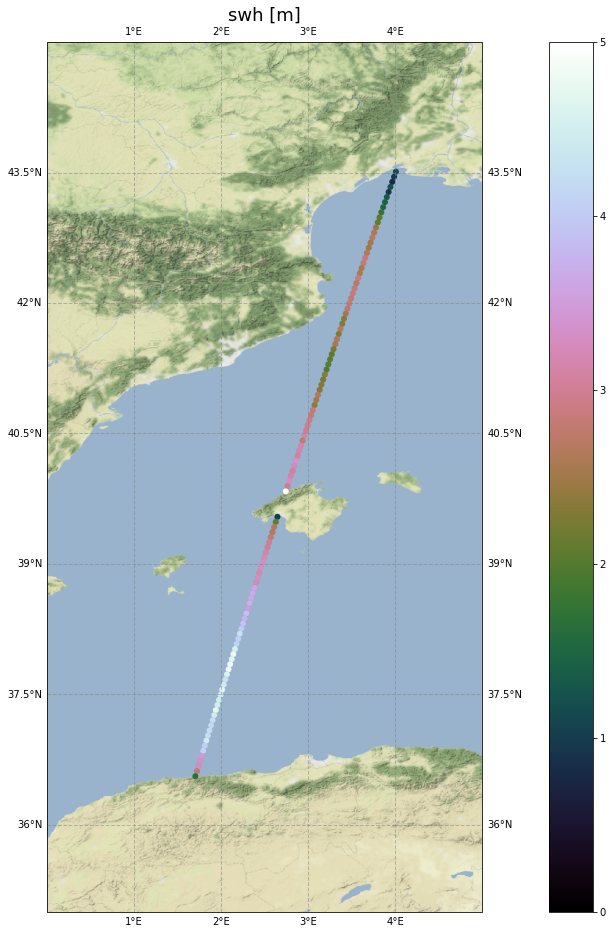

In [75]:
# load the data ; we take the Significant Wave Height field at 1 Hz in Ku band, SAR-mode (plrm would do, too), 
# over ocean surfaces.
lat = ncalti['lat_01']
lon = ncalti['lon_01']
swh = ncalti.variables['swh_ocean_01_ku']
lat = lat[ ncalti['surf_class_01']==0 ]
lon = lon[ ncalti['surf_class_01']==0 ]
swh = swh[ ncalti['surf_class_01']==0 ]

#plot it on a map
fig = plt.figure(figsize=(24,16))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='lightgrey')
#ax.add_feature(cartopy.feature.BORDERS)

ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
tiler = cimgt.Stamen('terrain-background')
zoom = 8
ax.add_image(tiler, zoom)


# actually plot the data
tracks = ax.scatter(lon, lat, c=swh,  vmin=0, vmax=5, cmap='cubehelix', marker='o', edgecolors='black', linewidth=0.01)
cbar = plt.colorbar(tracks)
plt.title('swh [m]', size=18)
plt.show()

C:\Users\vrosmorduc.GROUPCLS\Anaconda3\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\vrosmorduc.GROUPCLS\Anaconda3\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\vrosmorduc.GROUPCLS\Anaconda3\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


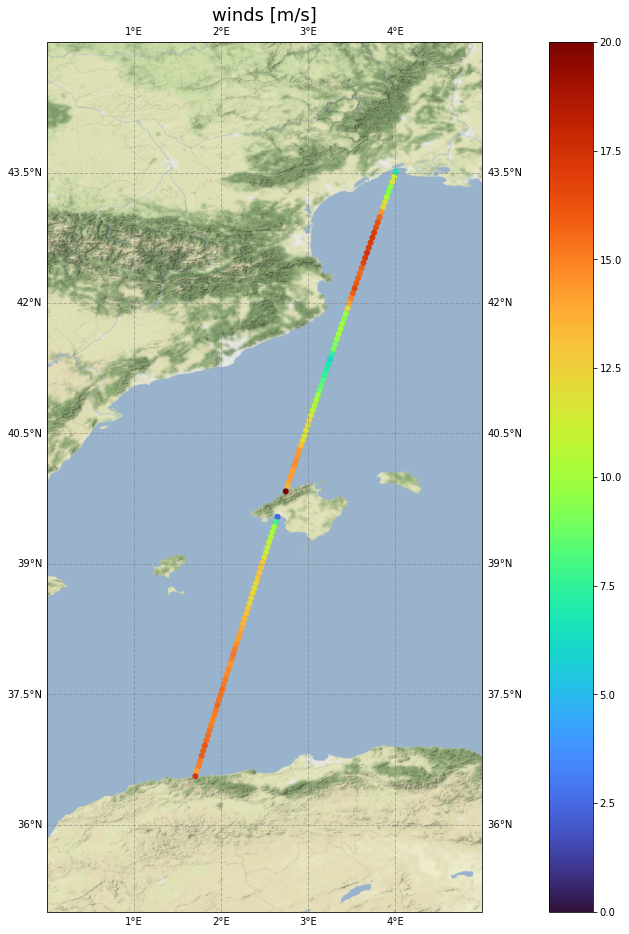

In [76]:
# load the data ; we take the Significant Wave Height field at 1 Hz in Ku band
#wind_speed_alt_01_plrm_ku
winds = ncalti.variables['wind_speed_alt_01_ku']
winds = winds[ ncalti['surf_class_01']==0 ]

#plot it on a map
fig = plt.figure(figsize=(24,16))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
tiler = cimgt.Stamen('terrain-background')
zoom = 8
ax.add_image(tiler, zoom)
# actually plot the data
tracks = ax.scatter(lon, lat, c=winds,  vmin=0, vmax=20, cmap='turbo', marker='o', edgecolors='black', linewidth=0.01)
cbar = plt.colorbar(tracks)
plt.title('winds [m/s]', size=18)
plt.show()
ncalti.close()

Plot along the latitude only, to have another look at the dynamic of the wave heights. 

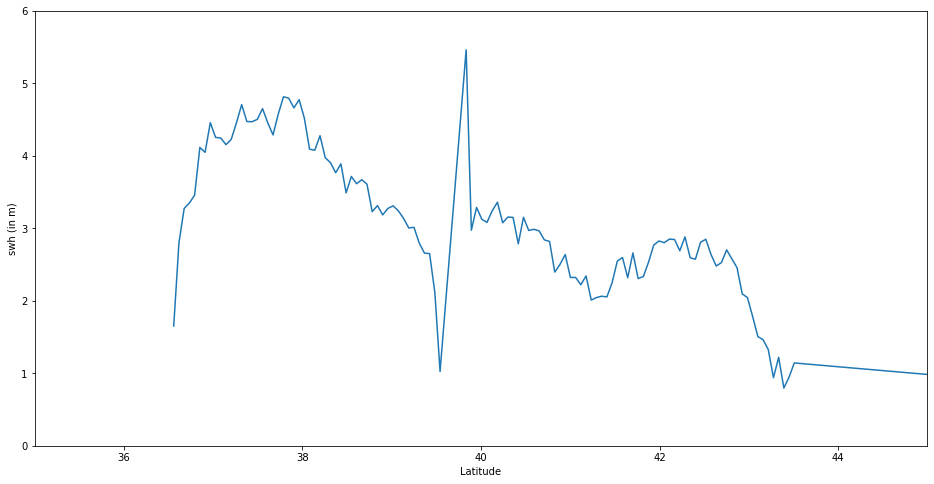

In [77]:
fig = plt.figure(figsize=(16,8))
plt.ylabel('swh (in m)')
plt.xlabel('Latitude')
plt.axis([lat_min, lat_max, 0, 6])
plt.plot(lat, swh)

Plot also the winds along the latitude only

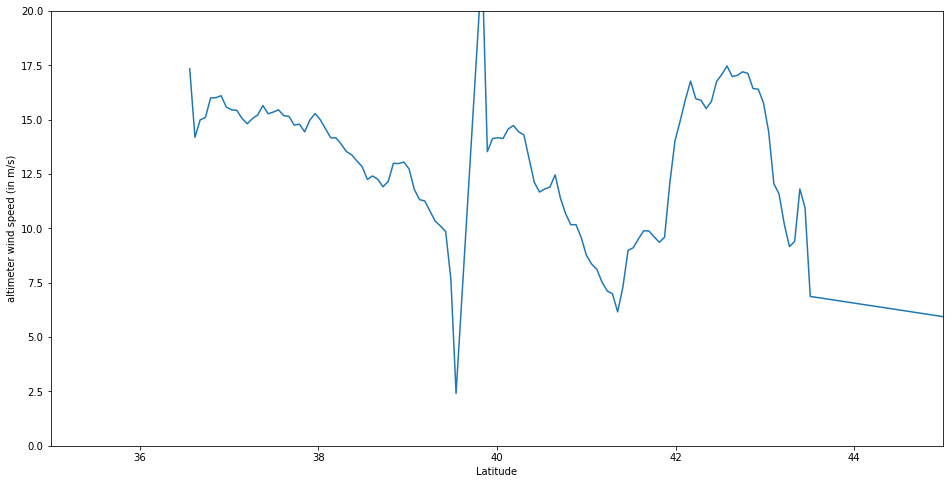

In [78]:
fig = plt.figure(figsize=(16,8))
plt.ylabel('altimeter wind speed (in m/s)')
plt.xlabel('Latitude')
plt.axis([lat_min, lat_max, 0, 20])
plt.plot(lat, winds)

## SAR wind data ##
Extreme winds data are available through www.esa-cyms.org (on the ftp data access).

SAR data at 5:53 UTC, alti data at about 10:20 UTC (file from 10:04 to 10:52), so more than 4 hours after -- winds had time to change.

Text(0.5, 1.0, 'wind speed [m/s]')

C:\Users\vrosmorduc.GROUPCLS\Anaconda3\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\vrosmorduc.GROUPCLS\Anaconda3\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\vrosmorduc.GROUPCLS\Anaconda3\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


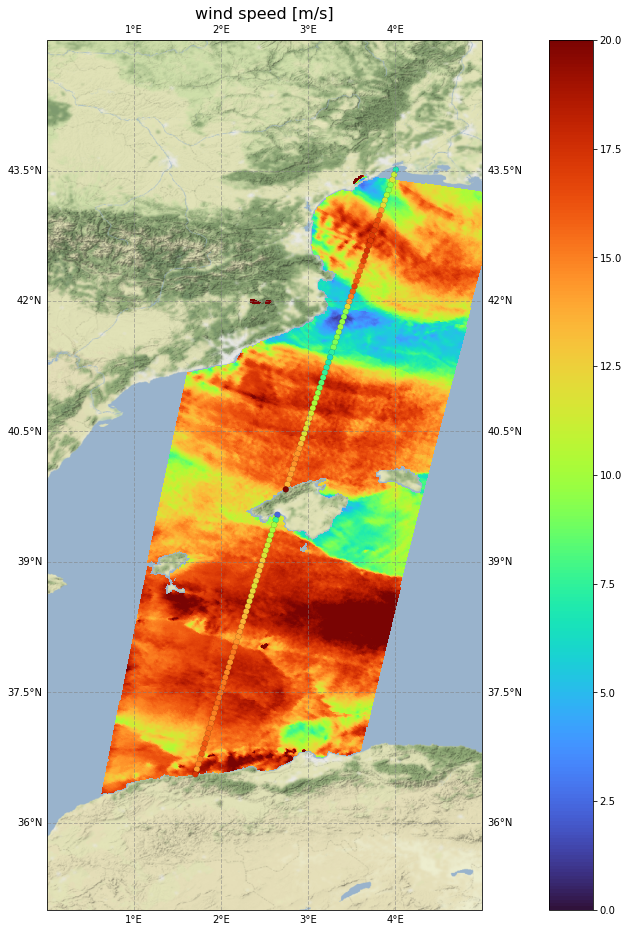

In [79]:
sar_file = 'data/s1a-iw-owi-cm-20230118t055303-20230118t055508-000003-046834_gs.nc'

#plot it on a map
fig = plt.figure(figsize=(24,16))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
tiler = cimgt.Stamen('terrain-background')
zoom = 8
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='lightgrey')
ax.add_image(tiler, zoom)

ncsar = xarray.load_dataset(sar_file)
latsar = ncsar.variables['latitude'][0]
lonsar = ncsar.variables['longitude'][0]
windsar = ncsar.variables['wind_speed'][0]
mymap = ax.pcolor(lonsar, latsar, windsar, vmin=0, vmax=20, cmap='turbo')
tracks = ax.scatter(lon, lat, c=winds,  vmin=0, vmax=20, cmap='turbo', marker='o', edgecolors='black', linewidth=0.1)
ncsar.close()

# add colorbar
cbar = plt.colorbar(mymap)
plt.title('wind speed [m/s]', size=16)